[link text](https://)# BERT Tutorial- How To Build a Question Answering Bot

Article by Michel Kana: https://towardsdatascience.com/bert-nlp-how-to-build-a-question-answering-bot-98b1d1594d7b

Code credits to Michel Kana, and Prachur Bhargava, Lead Data Scientist @ Microsoft

In [32]:
# verify GPU availability
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [33]:
# install huggingface libraries
!pip install pytorch-pretrained-bert pytorch-nlp pytorch_transformers  --q

In [34]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig, BertModel
from pytorch_transformers import AdamW, BertForQuestionAnswering
from tqdm import tqdm, trange
import pandas as pd
import io
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [36]:
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py'
!wget 'https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py'

--2021-08-12 08:32:21--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41529 (41K) [text/plain]
Saving to: ‘utils_squad.py.4’

utils_squad.py.4    100%[===================>]  40.56K  --.-KB/s    in 0.003s  

2021-08-12 08:32:21 (11.9 MB/s) - ‘utils_squad.py.4’ saved [41529/41529]

--2021-08-12 08:32:22--  https://raw.githubusercontent.com/nlpyang/pytorch-transformers/master/examples/utils_squad_evaluate.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response.

In [37]:
from google.colab import drive
drive.mount('/content/drive/',  force_remount=True)

Mounted at /content/drive/


In [38]:
!ls /content/drive/MyDrive/squadv2.0

checkpoint-2000  checkpoint-4000  train-v2.0.json
checkpoint-3000  dev-v2.0.json


In [39]:
from utils_squad import (read_squad_examples, convert_examples_to_features,
                         RawResult, write_predictions,
                         RawResultExtended, write_predictions_extended)
from utils_squad_evaluate import EVAL_OPTS, main as evaluate_on_squad, plot_pr_curve

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [41]:
input_file = '/content/drive/MyDrive/squadv2.0/train-v2.0.json'
examples = read_squad_examples(input_file=input_file,
                                is_training=True,
                                version_2_with_negative=True)

In [42]:
examples[:5]

[qas_id: 56be85543aeaaa14008c9063, question_text: When did Beyonce start becoming popular?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".], start_position: 39, end_position: 42,
 qas_id: 56be85543aeaaa14008c9065, question_text: What areas did Beyonce compete in when she was growing up?, doc_tokens: [Beyoncé Giselle Knowles-Carter (/biːˈ

In [43]:
train_data = pd.DataFrame.from_records([vars(example) for example in examples])
train_data.head()

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
0,56be85543aeaaa14008c9063,When did Beyonce start becoming popular?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",in the late 1990s,39,42,False
1,56be85543aeaaa14008c9065,What areas did Beyonce compete in when she was...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",singing and dancing,28,30,False
2,56be85543aeaaa14008c9066,When did Beyonce leave Destiny's Child and bec...,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",2003,82,82,False
3,56bf6b0f3aeaaa14008c9601,In what city and state did Beyonce grow up?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...","Houston, Texas",22,23,False
4,56bf6b0f3aeaaa14008c9602,In which decade did Beyonce become famous?,"[Beyoncé, Giselle, Knowles-Carter, (/biːˈjɒnse...",late 1990s,41,42,False


In [44]:
sample = train_data.sample(frac=1).head(1)
context = sample.doc_tokens.values
train_data[train_data.doc_tokens.values==context]

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible
125134,573257950fdd8d15006c69eb,What action in 2007 by national governments pr...,"[It, threatened, the, collapse, of, large, fin...",bailout of banks,13,15,False
125135,573257950fdd8d15006c69ec,How much estimated consumer wealth was lost as...,"[It, threatened, the, collapse, of, large, fin...",trillions of U.S. dollars,58,61,False
125136,573257950fdd8d15006c69ed,What is the date the active phase of the finan...,"[It, threatened, the, collapse, of, large, fin...","August 9, 2007",97,99,False
125137,573257950fdd8d15006c69ee,What year did the global recession that follow...,"[It, threatened, the, collapse, of, large, fin...",2012,71,71,False
125138,573257950fdd8d15006c69ef,What was the name of the company that terminat...,"[It, threatened, the, collapse, of, large, fin...",BNP Paribas,101,102,False


In [45]:
import random
def print_squad_sample(train_data, line_length=14, separator_length=120):
  sample = train_data.sample(frac=1).head(1)
  context = sample.doc_tokens.values
  print('='*separator_length)
  print('CONTEXT: ')
  print('='*separator_length)
  lines = [' '.join(context[0][idx:idx+line_length]) for idx in range(0, len(context[0]), line_length)]
  for l in lines:
      print(l)
  print('='*separator_length)
  questions = train_data[train_data.doc_tokens.values==context]
  print('QUESTION:', ' '*(3*separator_length//4), 'ANSWER:')
  for idx, row in questions.iterrows():
    question = row.question_text
    answer = row.orig_answer_text
    print(question, ' '*(3*separator_length//4-len(question)+9), (answer if answer else 'No awnser found'))

In [46]:
print_squad_sample(train_data)

CONTEXT: 
In total, 156 prisoners have been either acquitted, or received pardons or commutations on
the basis of possible innocence, between 1973 to 2015. Death penalty opponents often argue
that this statistic shows how perilously close states have come to undertaking wrongful executions;
proponents point out that the statistic refers only to those exonerated in law, and
that the truly innocent may be a smaller number. Statistics likely understate the actual
problem of wrongful convictions because once an execution has occurred there is often insufficient
motivation and finance to keep a case open, and it becomes unlikely at that
point that the miscarriage of justice will ever be exposed.
QUESTION:                                                                                            ANSWER:
Between 1973 and 2015, how amny prisoners were acquitted or received pardons or commutations of their death sentences due to possible innocence?  156
Between 1973 and 2015, how many prisoners

In [47]:

train_data['paragraph_len'] = train_data['doc_tokens'].apply(len)
train_data['question_len'] = train_data['question_text'].apply(len)
train_data.sample(frac=1).head(5)

,qas_id,question_text,doc_tokens,orig_answer_text,start_position,end_position,is_impossible,paragraph_len,question_len
36253,570b1d3d6b8089140040f721,Original 360 Alpha dev kits used what existing...,"[Known, during, development, as, Xbox, Next,, ...",Apple's Power Mac G5,111,114,False,201,65
105516,5a87b5c11d3cee001a6a1315,What can electrical systems be used to drive o...,"[Manifold, vacuum, can, be, used, to, drive, a...",,-1,-1,True,95,60
48310,571d2b4ddd7acb1400e4c237,What is the length of time of market exclusivi...,"[There, are, special, rules, for, certain, rar...",seven years,76,77,False,87,67
110368,572fc5c004bcaa1900d76cec,What are produced in cell division?,"[Unlike, in, multicellular, organisms,, increa...",two identical clone daughter cells,62,66,False,118,35
7705,5ad5fa5f5b96ef001a10af82,What kind of classes are offered in Mittelschule?,"[The, ""Mittelschule"", is, a, school, in, some,...",,-1,-1,True,62,49


In [48]:
max_seq_length = 256
print("Percentage of context's less than max_seq_length = %s%%" % (len([l for l in train_data['paragraph_len'] if l <= max_seq_length])/len(train_data) * 100))

Percentage of context's less than max_seq_length = 98.19289589392184%


In [49]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [50]:
doc_stride = 128
max_seq_length = 256
max_query_length = 64
# batch size of 64 if RAM available.
batch_size = 32

In [51]:
cached_features_file = '/content/drive/MyDrive/cache_train'

In [52]:
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=True)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [53]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [54]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_start_positions = torch.tensor([f.start_position for f in features], dtype=torch.long)
all_end_positions = torch.tensor([f.end_position for f in features], dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_start_positions, all_end_positions,
                        all_cls_index, all_p_mask)

In [55]:
train_sampler = RandomSampler(dataset)
train_dataloader = DataLoader(dataset, sampler=train_sampler, batch_size=batch_size, drop_last=True)

In [56]:
import glob
checkpoints = sorted(glob.glob('/content/drive/MyDrive/squadv2.0/checkpoint*-[0-9]*'))

In [57]:
def to_list(tensor):
    return tensor.detach().cpu().tolist()

In [58]:
if len(checkpoints) > 0:
    global_step = checkpoints[-1].split('-')[-1]
    ckpt_name = '/content/drive/MyDrive/squadv2.0/checkpoint-{}'.format(global_step)
    print("Loading model from checkpoint %s" % ckpt_name)
    model = BertForQuestionAnswering.from_pretrained(ckpt_name)
    train_loss_set_ckpt = torch.load(ckpt_name + '/training_loss.pt')
    train_loss_set = to_list(train_loss_set_ckpt)
    tr_loss = train_loss_set[-1]
else:
    global_step = 0
    train_loss_set = []
    tr_loss = 0.0
    model = BertForQuestionAnswering.from_pretrained('bert-base-uncased')

model.cuda()

Loading model from checkpoint /content/drive/MyDrive/squadv2.0/checkpoint-4000


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [59]:
param_optimizer = list(model.named_parameters())
print(param_optimizer[-2])
print(param_optimizer[-1])

('qa_outputs.weight', Parameter containing:
tensor([[ 0.0137,  0.0078, -0.0311,  ..., -0.0444, -0.0093,  0.0328],
        [ 0.0109, -0.0540, -0.0175,  ..., -0.0117, -0.0205, -0.0119]],
       device='cuda:0', requires_grad=True))
('qa_outputs.bias', Parameter containing:
tensor([0.0100, 0.0099], device='cuda:0', requires_grad=True))


In [60]:
learning_rate = 5e-5
adam_epsilon= 1e-8
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)

In [63]:
global_step

'4000'

In [67]:
num_train_epochs = 1

print("***** Running training *****")
print("  Num examples = %d" % len(dataset))
print("  Num Epochs = %d" % num_train_epochs)
print("  Batch size = %d" % batch_size)
print("  Total optimization steps = %d" % (len(train_dataloader) // num_train_epochs))

model.zero_grad()
train_iterator = trange(num_train_epochs, desc="Epoch")
set_seed()

for _ in train_iterator:
    epoch_iterator = tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      global_step = int(global_step)
      if step < int(global_step) + 1:
        continue

      model.train()
      batch = tuple(t.to(device) for t in batch)

      inputs = {'input_ids':       batch[0],
                'attention_mask':  batch[1], 
                'token_type_ids':  batch[2],  
                'start_positions': batch[3], 
                'end_positions':   batch[4]}

      outputs = model(**inputs)

      loss = outputs[0]
      train_loss_set.append(loss)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      tr_loss += loss.item()
      optimizer.step()
      model.zero_grad()
      global_step += 1
    
      if global_step % 1000 == 0:
        print("Train loss: {}".format(tr_loss/global_step))
        output_dir = '/content/drive/MyDrive/squadv2.0/checkpoint-{}'.format(global_step)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
        model_to_save.save_pretrained(output_dir)
        torch.save(torch.tensor(train_loss_set), os.path.join(output_dir, 'training_loss.pt'))
        print("Saving model checkpoint to %s" % output_dir)









Epoch:   0%|          | 0/1 [00:00<?, ?it/s]








Iteration:   0%|          | 0/4508 [00:00<?, ?it/s]








Iteration:   3%|▎         | 130/4508 [00:00<00:03, 1293.63it/s]

***** Running training *****
  Num examples = 144262
  Num Epochs = 1
  Batch size = 32
  Total optimization steps = 4508











Iteration:   6%|▌         | 258/4508 [00:00<00:03, 1288.55it/s]








Iteration:   9%|▊         | 385/4508 [00:00<00:03, 1282.31it/s]








Iteration:  11%|█▏        | 518/4508 [00:00<00:03, 1294.97it/s]








Iteration:  15%|█▍        | 654/4508 [00:00<00:02, 1311.25it/s]








Iteration:  18%|█▊        | 790/4508 [00:00<00:02, 1323.06it/s]








Iteration:  21%|██        | 925/4508 [00:00<00:02, 1329.50it/s]








Iteration:  23%|██▎       | 1058/4508 [00:00<00:02, 1328.13it/s]








Iteration:  26%|██▋       | 1191/4508 [00:00<00:02, 1326.14it/s]








Iteration:  29%|██▉       | 1325/4508 [00:01<00:02, 1330.01it/s]








Iteration:  32%|███▏      | 1455/4508 [00:01<00:02, 1294.37it/s]








Iteration:  35%|███▌      | 1587/4508 [00:01<00:02, 1300.09it/s]








Iteration:  38%|███▊      | 1723/4508 [00:01<00:02, 1314.41it/s]








Iteration:  41%|████      | 1857/4508 [00:01<00:02, 1320.85it/s]








Iteration:  44%|████▍     | 1989/4508 [00:01<00:

In [69]:
output_dir = '/content/drive/MyDrive/squadv2.0/checkpoint-final'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)

In [74]:
train_loss_set_ckpt = torch.load('/content/drive/MyDrive/squadv2.0/checkpoint-final/training_loss.pt')

train_loss_set = to_list(train_loss_set_ckpt)

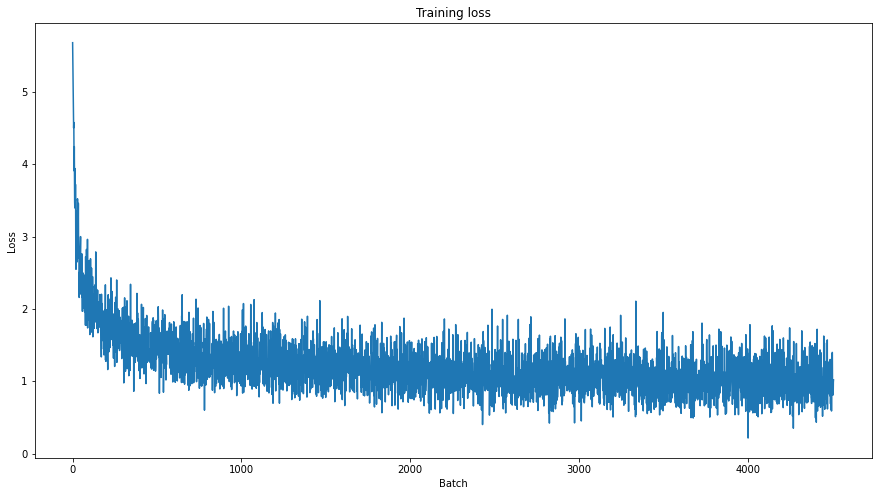

In [73]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

**Load test dataset**

In [75]:
input_file = '/content/drive/MyDrive/squadv2.0/dev-v2.0.json'
val_examples = read_squad_examples(input_file=input_file,
                                is_training=False,
                                version_2_with_negative=True)
doc_stride = 128
max_seq_length = 256
max_query_length = 64
cached_features_file = '/content/drive/MyDrive/cache_validation'

# Cache features for faster loading
if not os.path.exists(cached_features_file):
  features = convert_examples_to_features(examples=val_examples,
                                        tokenizer=tokenizer,
                                        max_seq_length=max_seq_length,
                                        doc_stride=doc_stride,
                                        max_query_length=max_query_length,
                                        is_training=False)
  torch.save(features, cached_features_file)
else:
  features = torch.load(cached_features_file)

In [76]:
# Convert to Tensors and build dataset
all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
all_cls_index = torch.tensor([f.cls_index for f in features], dtype=torch.long)
all_p_mask = torch.tensor([f.p_mask for f in features], dtype=torch.float)

all_example_index = torch.arange(all_input_ids.size(0), dtype=torch.long)
dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids,
                        all_example_index, all_cls_index, all_p_mask)

In [77]:
validation_sampler = SequentialSampler(dataset)
validation_dataloader = DataLoader(dataset, sampler=validation_sampler, batch_size=batch_size, drop_last=True)

**Evaluate test dataset**

In [80]:

def evaluate(model, tokenizer):
  print("***** Running evaluation *****")
  print("  Num examples = %d" % len(dataset))
  print("  Batch size = %d" % batch_size)
  all_results = []
  predict_file = '/content/drive/MyDrive/squadv2.0/dev-v2.0.json'
  for batch in tqdm(validation_dataloader, desc="Evaluating", miniters=100, mininterval=5.0):
    model.eval()
    batch = tuple(t.to(device) for t in batch)
    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2]
                }
      example_indices = batch[3]
      outputs = model(**inputs)

    for i, example_index in enumerate(example_indices):
      eval_feature = features[example_index.item()]
      unique_id = int(eval_feature.unique_id)

      result = RawResult(unique_id    = unique_id,
                         start_logits = to_list(outputs[0][i]),
                         end_logits   = to_list(outputs[1][i]))
      all_results.append(result)

  # Compute predictions
  output_prediction_file = "/content/drive/MyDrive/squadv2.0/predictions.json"
  output_nbest_file = "/content/drive/MyDrive/squadv2.0/nbest_predictions.json"
  output_null_log_odds_file = "/content/drive/MyDrive/squadv2.0/null_odds.json"
  output_dir = "/content/drive/MyDrive/squadv2.0/predict_results"

  write_predictions(val_examples, features, all_results, 10,
                  30, True, output_prediction_file,
                  output_nbest_file, output_null_log_odds_file, False,
                  True, 0.0)

  # Evaluate with the official SQuAD script
  evaluate_options = EVAL_OPTS(data_file=predict_file,
                               pred_file=output_prediction_file,
                               na_prob_file=output_null_log_odds_file,
                               out_image_dir=None)
  results = evaluate_on_squad(evaluate_options)
  return results

In [81]:
results = evaluate(model, tokenizer)









Evaluating:   0%|          | 0/425 [00:00<?, ?it/s]

***** Running evaluation *****
  Num examples = 13600
  Batch size = 32










Evaluating:   0%|          | 0/425 [00:10<?, ?it/s]







Evaluating:   9%|▉         | 38/425 [00:10<01:48,  3.58it/s]







Evaluating:  13%|█▎        | 56/425 [00:15<01:43,  3.58it/s]







Evaluating:  17%|█▋        | 74/425 [00:20<01:38,  3.58it/s]







Evaluating:  22%|██▏       | 92/425 [00:25<01:32,  3.58it/s]







Evaluating:  26%|██▌       | 110/425 [00:30<01:27,  3.58it/s]







Evaluating:  30%|███       | 128/425 [00:35<01:22,  3.59it/s]







Evaluating:  34%|███▍      | 146/425 [00:40<01:17,  3.58it/s]







Evaluating:  39%|███▊      | 164/425 [00:45<01:12,  3.58it/s]







Evaluating:  43%|████▎     | 182/425 [00:50<01:07,  3.58it/s]







Evaluating:  47%|████▋     | 200/425 [00:55<01:02,  3.58it/s]







Evaluating:  51%|█████▏    | 218/425 [01:00<00:57,  3.58it/s]







Evaluating:  56%|█████▌    | 236/425 [01:05<00:52,  3.58it/s]







Evaluating:  60%|█████▉    | 254/425 [01:10<00:47,  3.58it/s]







Evaluating:  64%|██████▍   | 272/425 [01

{
  "exact": 70.26025435862883,
  "f1": 73.4429145868012,
  "total": 11873,
  "HasAns_exact": 67.27395411605939,
  "HasAns_f1": 73.64840163446155,
  "HasAns_total": 5928,
  "NoAns_exact": 73.23801513877208,
  "NoAns_f1": 73.23801513877208,
  "NoAns_total": 5945,
  "best_exact": 70.62242061820939,
  "best_exact_thresh": -0.4445462226867676,
  "best_f1": 73.65357441378065,
  "best_f1_thresh": -0.4445462226867676
}


In [82]:
import json
results_json = []
for k in enumerate(results.keys()):
  result_dict = {k[1] : results[k[1]]}
  results_json.append(result_dict)
print(results_json)
with open('results.json', 'w') as f:
  json.dump(results_json, f)

[{'exact': 70.26025435862883}, {'f1': 73.4429145868012}, {'total': 11873}, {'HasAns_exact': 67.27395411605939}, {'HasAns_f1': 73.64840163446155}, {'HasAns_total': 5928}, {'NoAns_exact': 73.23801513877208}, {'NoAns_f1': 73.23801513877208}, {'NoAns_total': 5945}, {'best_exact': 70.62242061820939}, {'best_exact_thresh': -0.4445462226867676}, {'best_f1': 73.65357441378065}, {'best_f1_thresh': -0.4445462226867676}]


**Evaluate on any text**